# Sentiment Prediction on E-Commerce reviews based using RNN (LSTM)

In this notebook we focused on sentiment analysis using Deep Neural Network. There are mainly two types of Neural Network -
1. Convolution Neural Network (CNN)
2. Recurrent Neural Neural Network (RNN)

CNN is mainly used in image classification. Whereas, RNN is mainly used in time series and sequence data. We have already used a number of different Machine Learning Algorithms which gave us an acuracy in the range of 0.80.

In RNN, the output of one layer serves as the input of the next layer. Hence, it works better than any machine learning model. But, the output of first layer have lower impact on the final output than the impact of the output of second last layer.

To overcome this situation, we use LSTM to overcome this drawback as LSTM architeture has an extra cell state which is not present in RNN.

URL for more insigts - https://colah.github.io/posts/2015-08-Understanding-LSTMs/

NB: Total datasize was too large.As it was taking long time to run, I used 10% for train and 5% for test and few layers in LSTM

In [1]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

In [2]:
df = pd.read_csv('E-Commerce Reviews.csv')

In [3]:
for column in ["Division Name","Department Name","Class Name","Review Text"]:
    df = df[df[column].notnull()]
df.drop(df.columns[0], inplace=True, axis=1)

In [4]:
df.shape

(22628, 10)

In [5]:
df['Label'] = 0

In [6]:
df.loc[df.Rating >= 3, ['Label']] = 1

In [7]:
df['Word Count'] = df['Review Text'].str.split().apply(len)

In [8]:
df.sample(5)

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Label,Word Count
20662,726,48,Love,I absolutely love this pullover and am so glad...,5,1,1,Initmates,Intimate,Lounge,1,86
19550,1078,32,Fabric stretches throughout the day,This dress is beautiful. very vibrant and rich...,3,0,2,General Petite,Dresses,Dresses,1,51
3736,936,43,Perfect with everything,I received this as a gift and have seldom been...,5,1,9,General,Tops,Sweaters,1,90
14159,1129,43,Love this coat!,It was bit on pricey side but it was love at f...,5,1,2,General,Jackets,Outerwear,1,62
19314,1078,52,Great dress to dress up or down - runs big,"I usually find maeve to run tts, but i sized d...",4,1,1,General Petite,Dresses,Dresses,1,80


In [9]:
df.describe().T.drop('count', axis=1)

,mean,std,min,25%,50%,75%,max
Clothing ID,919.695908,201.683804,1.0,861.0,936.0,1078.0,1205.0
Age,43.282880,12.328176,18.0,34.0,41.0,52.0,99.0
Rating,4.183092,1.115911,1.0,4.0,5.0,5.0,5.0
Recommended IND,0.818764,0.385222,0.0,1.0,1.0,1.0,1.0
Positive Feedback Count,2.631784,5.787520,0.0,0.0,1.0,3.0,122.0
Label,0.895263,0.306222,0.0,1.0,1.0,1.0,1.0
Word Count,60.211950,28.533053,2.0,36.0,59.0,88.0,115.0


In [10]:
df[['Title', 'Division Name', 'Department Name', 'Class Name']].describe(include=['O']).T.drop('count', axis=1)

,unique,top,freq
Title,13983,Love it!,136
Division Name,3,General,13365
Department Name,6,Tops,10048
Class Name,20,Dresses,6145


## Recommended IND Classification

In [11]:
reviews = df['Review Text'].astype(str).str.lower()

In [12]:
type(reviews)

pandas.core.series.Series

In [13]:
features = reviews.tolist()

In [14]:
features

['absolutely wonderful - silky and sexy and comfortable',
 'love this dress!  it\'s sooo pretty.  i happened to find it in a store, and i\'m glad i did bc i never would have ordered it online bc it\'s petite.  i bought a petite and am 5\'8".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.',
 'i had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c',
 "i love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments

In [15]:
import re
from string import punctuation

In [16]:
for index in range(len(features)):
    all_text = ''.join([character for character in features[index] if character not in punctuation])
    features[index] = re.split(r'\n|\r', all_text)
    features[index] = ' '.join([word for word in features[index]])

In [17]:
features

['absolutely wonderful  silky and sexy and comfortable',
 'love this dress  its sooo pretty  i happened to find it in a store and im glad i did bc i never would have ordered it online bc its petite  i bought a petite and am 58  i love the length on me hits just a little below the knee  would definitely be a true midi on someone who is truly petite',
 'i had such high hopes for this dress and really wanted it to work for me i initially ordered the petite small my usual size but i found this to be outrageously small so small in fact that i could not zip it up i reordered it in petite medium which was just ok overall the top half was comfortable and fit nicely but the bottom half had a very tight under layer and several somewhat cheap net over layers imo a major design flaw was the net over layer sewn directly into the zipper  it c',
 'i love love love this jumpsuit its fun flirty and fabulous every time i wear it i get nothing but great compliments',
 'this shirt is very flattering to al

In [18]:
labels = np.array(df['Recommended IND'], np.int)

In [19]:
labels.shape

(22628,)

In [20]:
labels[labels == 1].shape[0]

18527

In [21]:
labels[labels == 0].shape[0]

4101

In [22]:
from keras.utils import to_categorical

Using TensorFlow backend.
C:\Users\HP\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\HP\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\HP\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\HP\Anaconda3\envs\te

In [23]:
labels = to_categorical(labels)

In [24]:
labels[:10]

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [25]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [26]:
t = Tokenizer()
t.fit_on_texts(features)
vocabulary_size = len(t.word_index) + 1

In [27]:
print('Vocabulary size : {}'.format(vocabulary_size))

Vocabulary size : 19370


In [28]:
encoded_features = t.texts_to_sequences(features)

max_length = 300

padded_features = pad_sequences(encoded_features, maxlen=max_length, padding='post')

In [33]:
embeddings_index = dict()
with open("H:/glove.840B.300d.txt", "r", encoding="utf8") as file:
    data = file.readlines()

    
# store <key, value> pair of FastText vectors
for line in data[1:]:
    word, vec = line.split(' ', 1)
    embeddings_index[word] = np.array([float(index) for index in vec.split()], dtype='float32')
print('Loaded {} word vectors.'.format(len(embeddings_index)))


embedding_matrix = np.zeros((vocabulary_size, max_length))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Loaded 2196015 word vectors.


In [34]:
words = []
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        words.append(word)

In [35]:
print('{} words covered.'.format(len(words)))

13911 words covered.


In [36]:
percentage = (len(words) / vocabulary_size) * 100.00
print('{}% of {} words were covered'.format(percentage, vocabulary_size))

71.81724315952503% of 19370 words were covered


In [37]:
def train_test_split(features, labels, **kwargs):
    
    # concatenate the features and labels array
    dataset = np.c_[features, labels]

    # shuffle the dataset
    np.random.shuffle(dataset)

    # split the dataset into features, labels
    features, labels = dataset[:, 0:max_length], dataset[:, max_length:]

    # get the split size for training dataset
    split_index = int(kwargs['train_size'] * len(features))

    # split the dataset into training/validation dataset
    train_features, validation_features = features[:split_index], features[split_index:]
    train_labels, validation_labels = labels[:split_index], labels[split_index:]

    # get the split size for validation dataset
    split_index = int(kwargs['validation_size'] * len(validation_features))

    # split the validation dataset into validation/testing dataset
    validation_features, test_features = validation_features[:split_index], validation_features[split_index:]
    validation_labels, test_labels = validation_labels[:split_index], validation_labels[split_index:]

    # return the partitioned dataset
    return [train_features, train_labels], [validation_features, validation_labels], [test_features, test_labels]

In [43]:
train_dataset, validation_dataset, test_dataset = train_test_split(features=padded_features, labels=labels,
                                                                   train_size=0.10, validation_size=0.05)

In [44]:
print('Dataset size : {}'.format(padded_features.shape[0]))
print('Train dataset size : {}'.format(train_dataset[0].shape[0]))
print('Validation dataset size : {}'.format(validation_dataset[0].shape[0]))
print('Test dataset size : {}'.format(test_dataset[0].shape[0]))

Dataset size : 22628
Train dataset size : 2262
Validation dataset size : 1018
Test dataset size : 19348


In [40]:
from keras import callbacks
from keras.layers import Bidirectional
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import LSTM
from keras.models import Sequential
from sklearn.model_selection import StratifiedKFold

In [45]:
model = Sequential()
e = Embedding(vocabulary_size, max_length,
              weights=[embedding_matrix], input_length=max_length, trainable=False)
model.add(e)
model.add(Bidirectional(LSTM(10)))
model.add(Dropout(0.50))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(train_dataset[0], train_dataset[1], epochs=5, batch_size=10, verbose=1,
          validation_data=(validation_dataset[0], validation_dataset[1]))

score = model.evaluate(test_dataset[0], test_dataset[1], verbose=1)

print('loss : {}, acc : {}'.format(score[0], score[1]))

Train on 2262 samples, validate on 1018 samples
Epoch 1/5
2262/2262 [==============================] - 61s 27ms/step - loss: 0.5305 - accuracy: 0.7889 - val_loss: 0.4468 - val_accuracy: 0.8261
Epoch 2/5
2262/2262 [==============================] - 60s 27ms/step - loss: 0.4978 - accuracy: 0.7991 - val_loss: 0.4328 - val_accuracy: 0.8261
Epoch 3/5
2262/2262 [==============================] - 62s 27ms/step - loss: 0.4554 - accuracy: 0.7975 - val_loss: 0.3682 - val_accuracy: 0.8384
Epoch 4/5
2262/2262 [==============================] - 62s 27ms/step - loss: 0.4035 - accuracy: 0.8192 - val_loss: 0.3384 - val_accuracy: 0.8600
Epoch 5/5
19348/19348 [==============================] - 146s 8ms/step
loss : 0.32338418635499855, acc : 0.8571686744689941


In [46]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

test_predictions = model.predict(test_dataset[0])
test_predictions = np.argmax(test_predictions, axis=1)

class_names = ['(0) Not recommended class', '(1) Recommended class']
report = classification_report(np.argmax(test_dataset[1], axis=1), test_predictions, target_names=class_names)

In [47]:
print(report)

                           precision    recall  f1-score   support

(0) Not recommended class       0.64      0.46      0.54      3470
    (1) Recommended class       0.89      0.94      0.92     15878

                 accuracy                           0.86     19348
                macro avg       0.77      0.70      0.73     19348
             weighted avg       0.84      0.86      0.85     19348



In [48]:
conf_matrix = confusion_matrix(np.argmax(test_dataset[1], axis=1), test_predictions)
print(conf_matrix)

[[ 1588  1882]
 [  875 15003]]


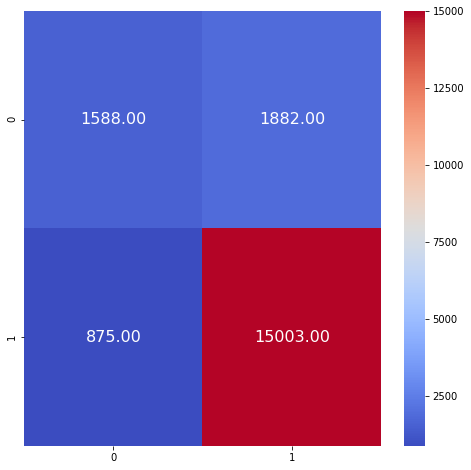

In [49]:
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, annot_kws={'size': 16}, cmap='coolwarm', fmt='.2f')
plt.savefig('conf_matrix_recommendation.png', format='png', dpi=300)

In [50]:
from sklearn.metrics import roc_auc_score

roc = roc_auc_score(y_score=test_predictions, y_true=np.argmax(test_dataset[1], 1))
print(roc)

0.7012645957123353


In [51]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(np.argmax(test_dataset[1], 1), test_predictions)
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.7012645957123353


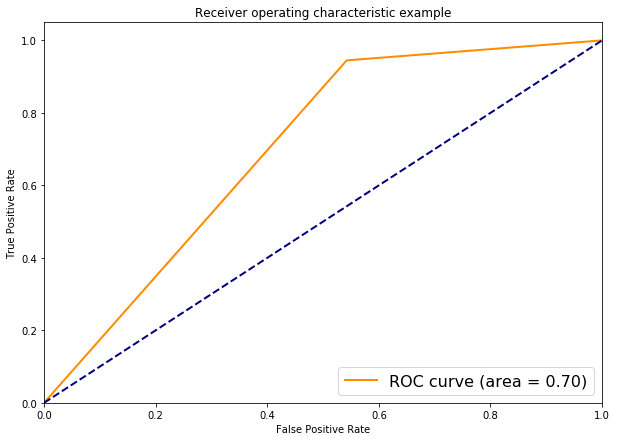

In [52]:
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, lw=2, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc='lower right', fontsize=16)
plt.savefig('roc.png', format='png', dpi=300)
plt.show()

## Sentiment Classification

In [57]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
# Pre-Processing
SIA = SentimentIntensityAnalyzer()
df["Review Text"]= df["Review Text"].astype(str)

# Applying Model, Variable Creation
df['Polarity Score']=df["Review Text"].apply(lambda x:SIA.polarity_scores(x)['compound'])
df['Neutral Score']=df["Review Text"].apply(lambda x:SIA.polarity_scores(x)['neu'])
df['Negative Score']=df["Review Text"].apply(lambda x:SIA.polarity_scores(x)['neg'])
df['Positive Score']=df["Review Text"].apply(lambda x:SIA.polarity_scores(x)['pos'])

# Converting 0 to 1 Decimal Score to a Categorical Variable
df['Sentiment']=''
df.loc[df['Polarity Score']>0,'Sentiment']='Positive'
df.loc[df['Polarity Score']==0,'Sentiment']='Neutral'
df.loc[df['Polarity Score']<0,'Sentiment']='Negative'

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [58]:
labels = np.array(df['Sentiment'])

In [59]:
labels

array(['Positive', 'Positive', 'Positive', ..., 'Positive', 'Positive',
       'Positive'], dtype=object)

In [60]:
labels = np.array([2 if label == 'Positive' else (1 if label == 'Neutral' else 0) for label in labels],
                  np.int)

In [61]:
labels

array([2, 2, 2, ..., 2, 2, 2])

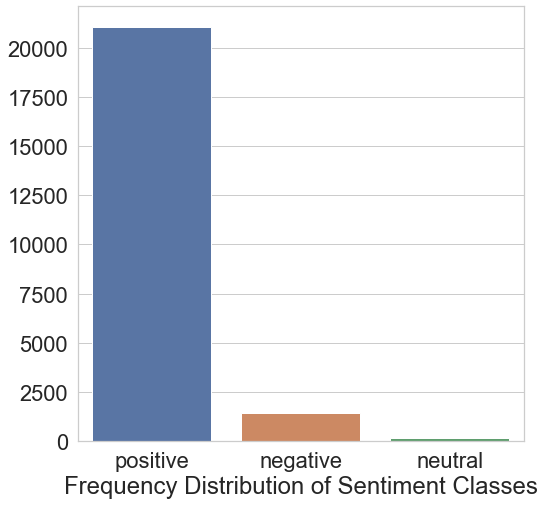

In [62]:
positive_class = int(labels[labels == 2].shape[0])
neutral_class = int(labels[labels == 1].shape[0])
negative_class = int(labels[labels == 0].shape[0])

df = pd.DataFrame.from_dict({'positive': [positive_class], 'negative': [negative_class], 'neutral': [neutral_class]})

plt.figure(figsize=(8, 8))
sns.set(font_scale=2)
sns.set_style('whitegrid')
ax = sns.barplot(data=df)
ax = ax.set_xlabel('Frequency Distribution of Sentiment Classes')

In [63]:
labels = to_categorical(labels)

In [66]:
train_dataset, validation_dataset, test_dataset = train_test_split(features=padded_features, labels=labels,
                                                                   train_size=0.10, validation_size=0.05)

In [67]:
model = Sequential()
e = Embedding(vocabulary_size, max_length,
              weights=[embedding_matrix], input_length=max_length, trainable=False)
model.add(e)
model.add(Bidirectional(LSTM(10), merge_mode='sum'))
model.add(Dropout(0.50))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(train_dataset[0], train_dataset[1], epochs=5, batch_size=10, verbose=1,
          validation_data=(validation_dataset[0], validation_dataset[1]))

score = model.evaluate(test_dataset[0], test_dataset[1], verbose=1)

print('loss : {}, acc : {}'.format(score[0], score[1]))

Train on 2262 samples, validate on 1018 samples
Epoch 1/5
2262/2262 [==============================] - 59s 26ms/step - loss: 0.4308 - accuracy: 0.8859 - val_loss: 0.2683 - val_accuracy: 0.9303
Epoch 2/5
2262/2262 [==============================] - 59s 26ms/step - loss: 0.3318 - accuracy: 0.9302 - val_loss: 0.2617 - val_accuracy: 0.9303
Epoch 3/5
2262/2262 [==============================] - 61s 27ms/step - loss: 0.2992 - accuracy: 0.9319 - val_loss: 0.2572 - val_accuracy: 0.9303
Epoch 4/5
2262/2262 [==============================] - 68s 30ms/step - loss: 0.2716 - accuracy: 0.9319 - val_loss: 0.2354 - val_accuracy: 0.9303
Epoch 5/5
19348/19348 [==============================] - 149s 8ms/step
loss : 0.2374658147387202, acc : 0.9303287267684937


In [68]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

test_predictions = model.predict(test_dataset[0])
test_predictions = np.argmax(test_predictions, axis=1)

class_names = ['(0) Negative class', '(1) Neutral class', '(2) Positive class']
report = classification_report(np.argmax(test_dataset[1], axis=1), test_predictions, target_names=class_names)

In [69]:
print(report)

                    precision    recall  f1-score   support

(0) Negative class       0.60      0.00      0.00      1230
 (1) Neutral class       0.33      0.01      0.02       120
(2) Positive class       0.93      1.00      0.96     17998

          accuracy                           0.93     19348
         macro avg       0.62      0.34      0.33     19348
      weighted avg       0.91      0.93      0.90     19348



In [70]:
conf_matrix = confusion_matrix(np.argmax(test_dataset[1], axis=1), test_predictions)
print(conf_matrix)

[[    3     2  1225]
 [    0     1   119]
 [    2     0 17996]]


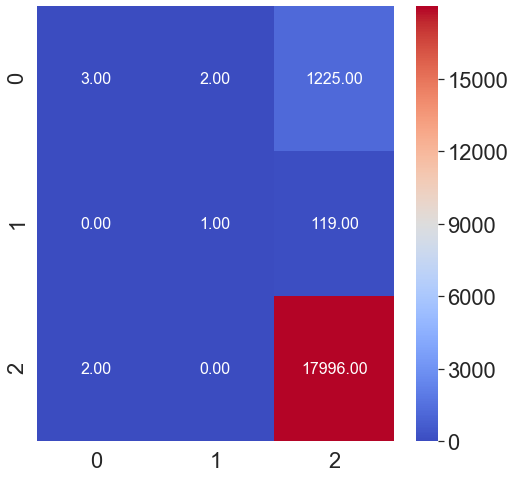

In [71]:
plt.figure(figsize=(8, 8))
plt.savefig('conf_matrix_sentiment.png', format='png', dpi=300)
sns.heatmap(conf_matrix, annot=True, annot_kws={'size': 16}, cmap='coolwarm', fmt='.2f')